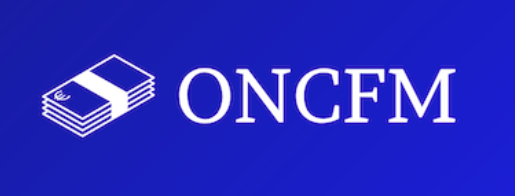

L'ONCFM renforce ses méthodes d’identification de faux billets.  
Objectifs :  
- mettre en place un algorithme capable de différencier les vrais billets des faux,  
- les vrais billets sont différenciés des faux  à partir de leurs caractéristiques géométriques.      

6 informations géométriques sur les billets (en mm) :
- length : longueur du billet,
- height_left : hauteur du billet (mesurée sur la gauche),
- height_right : hauteur du billet (mesurée sur la droite),
- margin_up : marge entre le bord supérieur du billet et l'image,
- margin_low : marge entre le bord inférieur du billet et l'image,
- diagonal : diagonale du billet.

*Charte graphique* :         
- 0 = true (vrai billet) en bleu      
- 1 = false (faux billet) en orange     

#### Introduction

In [1]:
# Standard library imports
from datetime import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import numpy as np
import os, sys
import pandas as pd
import re 
from scipy.stats import t, shapiro
import seaborn as sns

from sklearn import decomposition, preprocessing, cluster, metrics, neighbors, model_selection
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
# Régression Logistique
from sklearn.linear_model import LinearRegression, LogisticRegression
# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import precision_recall_fscore_support as score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
#affichage des versions des librairies
!python --version
print('\n'.join(f'{m.__name__} - {m.__version__}'
for m in globals().values() 
if getattr(m, '__version__', None)))

Python 3.9.12
numpy - 1.21.5
pandas - 1.4.2
re - 2.2.1
seaborn - 0.11.2
statsmodels - 0.13.2
statsmodels.api - 0.13.2


In [3]:
#os.getcwd()
#os.chdir('C:/Users/Matthieu')

In [4]:
#df_billets = pd.read_csv("..Documents/DAN-P10-data/billets.csv", sep=";")
df_billets = pd.read_csv("C:/Users/Matthieu/Documents/DAN-P10-data/billets.csv", sep=";")

#### I/-Inspection du Dataset      

##### I/-A/- Exploration du Dataset

In [5]:
# Affichage d'info, head et describe.
def analysis_df_start(df_input):
    display(df_input.info())
    display(df_input.head(5))
    display(df_input.isna().mean())
    display(df_input.isna().sum())
    display(df_input.describe(include="all"))
analysis_df_start(df_billets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


None

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


In [6]:
# définitions deq dimensions des visualisations
sns.set(rc={'figure.figsize':(17,12),
            'axes.titlesize': 'xx-large'})
color_green = '\033[92m'
color_red = '\033[91m'
# source : https://stackoverflow.com/questions/15580303/python-output-complex-line-with-floats-colored-by-value

In [7]:
# Indication des valeurs que prennent la variable "is_genuine"
df_billets['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [8]:
# Remplacement de False par 1 et True par 0 pour travailler plus facilement avec un "int" au lieu d'une "str".
df_billets['is_genuine'].replace([False,True], [1,0], inplace=True)
# définitions de deux df avec vrais et faux billets
df_faux = df_billets[df_billets['is_genuine'] == 1]
df_true = df_billets[df_billets['is_genuine'] == 0]

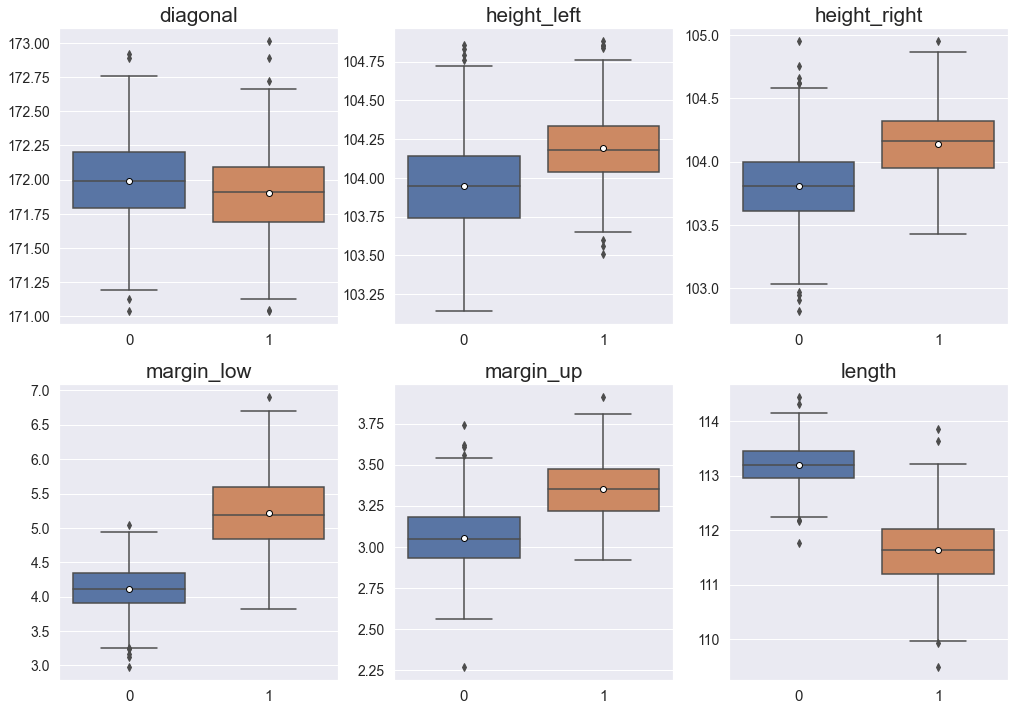

In [9]:
x=231
for i in range(df_billets.shape[1] - 1):
    plt.subplot(x)
    sns.boxplot(data=df_billets,
                    x="is_genuine", 
                    y=df_billets.columns[i + 1],
                    showmeans = True,
                    meanprops = {"marker" : "o",
                                 "markerfacecolor" : "white",
                                 "markeredgecolor" : "black"},                    
                    showfliers = True);
    plt.title(df_billets.columns[i + 1])
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=15)
    plt.xlabel("",fontsize=20)
    plt.ylabel("",fontsize=20)
    x += 1
# source : https://stackoverflow.com/questions/36220829/fine-control-over-the-font-size-in-s

In [10]:
# Vérification du nombre de faux billets
print("- Les vrais billets sont au nombre de",df_billets.loc[df_billets["is_genuine"]==True]["is_genuine"].count())
print("- Les faux billets sont au nombre de",df_billets.loc[df_billets["is_genuine"]==False]["is_genuine"].count())

- Les vrais billets sont au nombre de 500
- Les faux billets sont au nombre de 1000


##### I/-B/- Caractéristiques des faux billets

In [11]:
# Moyennes des variations (en %)

# var_diag
var_diag = (((df_billets.loc[df_billets["is_genuine"]==1]["diagonal"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["diagonal"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["diagonal"].mean()))*100

# height
var_left = (((df_billets.loc[df_billets["is_genuine"]==1]["height_left"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["height_left"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["height_left"].mean()))*100
var_right = (((df_billets.loc[df_billets["is_genuine"]==1]["height_right"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["height_right"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["height_right"].mean()))*100

# margin
var_low = (((df_billets.loc[df_billets["is_genuine"]==1]["margin_low"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["margin_low"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["margin_low"].mean()))*100
var_up = (((df_billets.loc[df_billets["is_genuine"]==1]["margin_up"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["margin_up"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["margin_up"].mean()))*100

# var_length
var_length = (((df_billets.loc[df_billets["is_genuine"]==1]["length"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["length"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["length"].mean()))*100

# Récapitulatif
pd.DataFrame(index=["Moyennes des variations (en %)"],columns=["diagonal","height_left","height_right","margin_low","margin_up","length"],data=[[var_diag, var_left, var_right, var_low, var_up, var_length]])


,diagonal,height_left,height_right,margin_low,margin_up,length
Moyennes des variations (en %),-0.049957,0.232046,0.32268,26.720415,9.764656,-1.388477


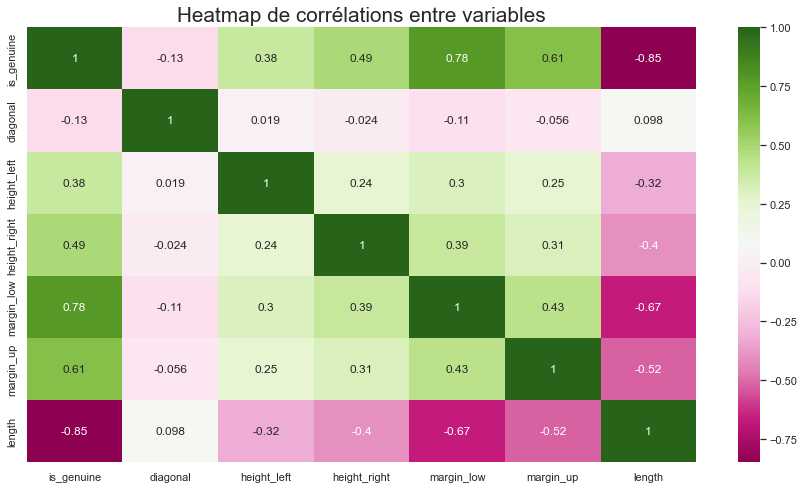

In [12]:
# Afficher la matrice de corrélation
plt.figure(figsize=(15,8))
plt.title("Heatmap de corrélations entre variables")
sns.heatmap(df_billets.corr(), annot=True, cmap="PiYG")
plt.show()

Commentaires :   
- Corrélations entre billet "véritable" : et sa "longueur" de 0.85 et sa "diagonale" de 0.13.     
- Corrélations entre "margin_low" : et la "longueur" de - 0.67 et "véritable" de - 0.78. 
- Caractéristiques des vrais billets : une diagonale et une longueur plus grandes ; une hauteur et des marges moins grandes.

##### I/-C/- Création de deux Datasets avec et sans valeurs manquantes     

In [13]:
# Dataset avec margin_low = NaN
df_na = df_billets.loc[df_billets["margin_low"].isna()]
# Dataset sans valeurs manquantes
df_val = df_billets.dropna()

#### II/-Régression linéaire    

##### II/-A/- Régression linéaire multiple    

In [14]:
# Fonction de selection automatique du modele
# Source : https://www.kaggle.com/code/mustaphabouyardan/regression-lineaire-multiple
def backward_selected(data, response):
        remaining = set(data._get_numeric_data().columns)
        if response in remaining:
            remaining.remove(response)
        cond = True
        while remaining and cond:
            formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
            print('_______________________________')
            print(formula)
            model = smf.ols(formula, data).fit()
            score = model.pvalues[1:]
            toRemove = score[score == score.max()]
            if toRemove.values > 0.05:
                print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
                remaining.remove(toRemove.index[0])
            else:
                cond = False
                print('is the final model')
            print('')
        print(model.summary())
        return model

In [15]:
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
backward_selected = backward_selected(df_val[columns], 'margin_low')

_______________________________
margin_low ~ length + margin_up + height_right + is_genuine + height_left + diagonal + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ margin_up + height_right + is_genuine + height_left + diagonal + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ margin_up + height_right + is_genuine + height_left + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ margin_up + is_genuine + height_left + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ margin_up + is_genuine + 1
is the final model

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Th

Commentaires :  
- Certains paramètres ne sont pas significativement différents de 0, leur p-valeur n'est pas inférieure à 5 %.    
- Le $R^{2}$ vaut environ 0.61, et le $R^{2}$ ajusté est d'environ 0.61.  
- On va conserver les variables significatives : is_genuine et margin_up  

In [16]:
df_fin= df_val.drop(['diagonal','length','height_right','height_left'],axis=1)

In [17]:
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=df_fin).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Thu, 19 Oct 2023   Prob (F-statistic):          1.24e-304
Time:                        10:08:16   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7631      0.180     26.521      0.0

On remarque qu'à présent, tous les paramètres sont significatifs. Quant au $R^{2}$, il vaut environ 0.6, tout comme le $R^{2}$ ajusté.

3 hypothèses sont à vérifier afin de voir si une régression linéaire est envisageable :     
- Non colinéarité : aucune corrélation linéaire entre les variables indépendantes (susceptibles d’agir sur la variable dépendante).   
- Homoscédasticité : les résidus ont la même variance quelle que soit la valeur de la variable explicative considérée dans le modèle de régression.            
- Normalité : les résidus doivent suivre une distribution normale.

###### II/-A/-1- Vérifier la colinéarité des variables :   

In [18]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
#source : COURS TP

[1.5938854494007748, 1.5938854494007746]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

###### II/-A/-2- Testez l’homoscédasticité : la constance de la variance des résidus

In [19]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.2033559115836335e-36


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (homoscédasticité).

In [20]:
model_train = df_fin

In [21]:
model_train["inverse_margin_low"] = 1/(model_train["margin_low"])
reg = smf.ols("inverse_margin_low~margin_up+is_genuine", data = model_train).fit()

In [22]:
def backward_selected(data, response):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
           evaluated by parameters p-value
    """
    
    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.ols(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model !')
        print('')
    print(model.summary())
    
    return model

In [23]:
reg = backward_selected(model_train.loc[:,model_train.columns != "margin_low"], "inverse_margin_low")

_______________________________
inverse_margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:     inverse_margin_low   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     1055.
Date:                Thu, 19 Oct 2023   Prob (F-statistic):          3.04e-284
Time:                        10:08:16   Log-Likelihood:                 3654.3
No. Observations:                1463   AIC:                            -7303.
Df Residuals:                    1460   BIC:                            -7287.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [24]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 0.3014385659369398


###### II/-A/-3- Testez la normalité des résidus

In [25]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.00 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

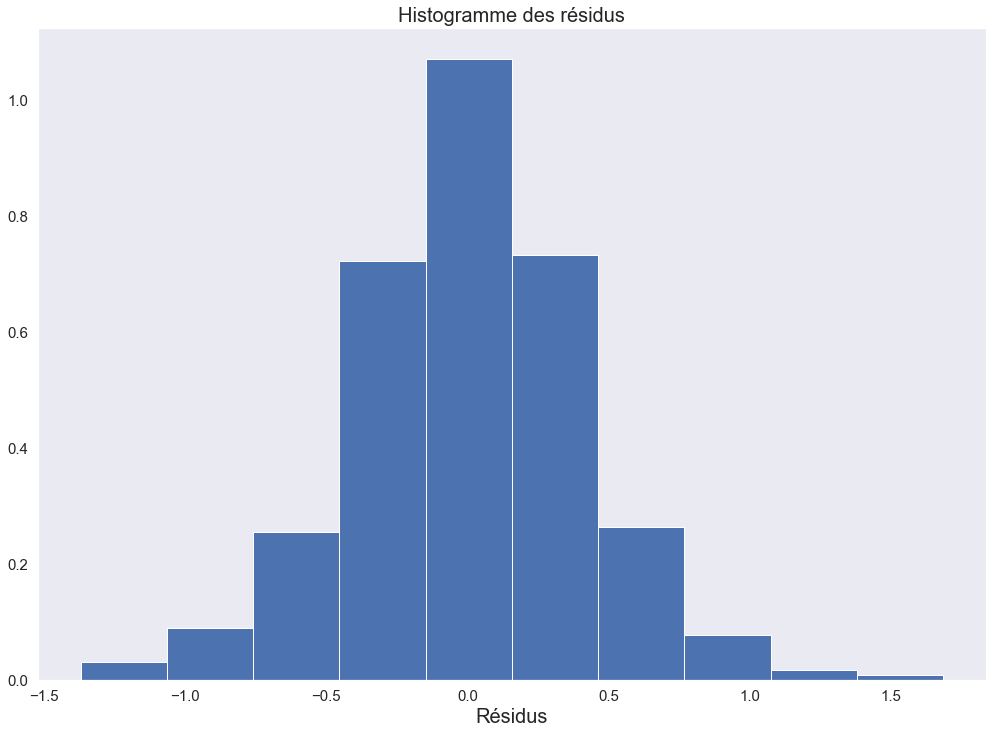

In [26]:
# création d'une colonne avec les résidus
df_fin['residu_s'] = reg_multi.resid
# affichage des résidus
plt.hist(df_fin['residu_s'], density=True)
plt.xlabel('Résidus', fontsize=20)
plt.ylabel("",fontsize=20)
plt.title('Histogramme des résidus', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid(False)
#plt.axis('off')
plt.show()

In [27]:
# création de "df_pred" avec les 3 colonnes significatives 
# assignation à 'val pred' des valeurs de la régression linéaire multiple
# colonne df_na['margin_low_pred'] avec les valeurs de 'val_pred' 
df_pred = df_na.drop(['diagonal','height_left','height_right','length'], axis = 1)
val_pred = reg_multi.predict(df_pred)
df_na['margin_low_pred'] = val_pred

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_7520\567879511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na['margin_low_pred'] = val_pred


In [28]:
# création de 'df_final' copie de 'df_billets'
# assignation des variables de 'margin_low_pred' aux valeurs manquantes
df_final = df_billets.copy()
df_final.loc[df_na.index, 'margin_low'] = df_na['margin_low_pred']

In [29]:
print("après prédiction")
display(df_final[["margin_low"]].describe())
print("avant prédiction")
display(df_billets[["margin_low"]].describe())

après prédiction


,margin_low
count,1500.000000
mean,4.482863
std,0.659849
min,2.980000
25%,4.027500
50%,4.310000
75%,4.870000
max,6.900000


avant prédiction


,margin_low
count,1463.000000
mean,4.485967
std,0.663813
min,2.980000
25%,4.015000
50%,4.310000
75%,4.870000
max,6.900000


Commentaire : les résultats de la prédiction semblent cohérents. On ne constate pas de décalage significatif depuis l'ajout des variables prédites par la régression linéaire.

##### II/-B/- ACP

In [30]:
# Centrage et réduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final)

In [31]:
pca = PCA(n_components=4)
pca.fit(X_scaled)

PCA(n_components=4)

In [32]:
scree = (pca.explained_variance_ratio_*100).round()
scree_cum = scree.cumsum().round()
scree_cum
# Commentaire : les 2 premières composantes captent 64% de la variance, les 3 premières captent 75% de la variance.

array([49., 64., 75., 85.])

In [33]:
# Travail sur les 4 premières composantes.
n_components = 4
# Définition de la variable 'x_list' avec la liste de nos composantes.
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4]

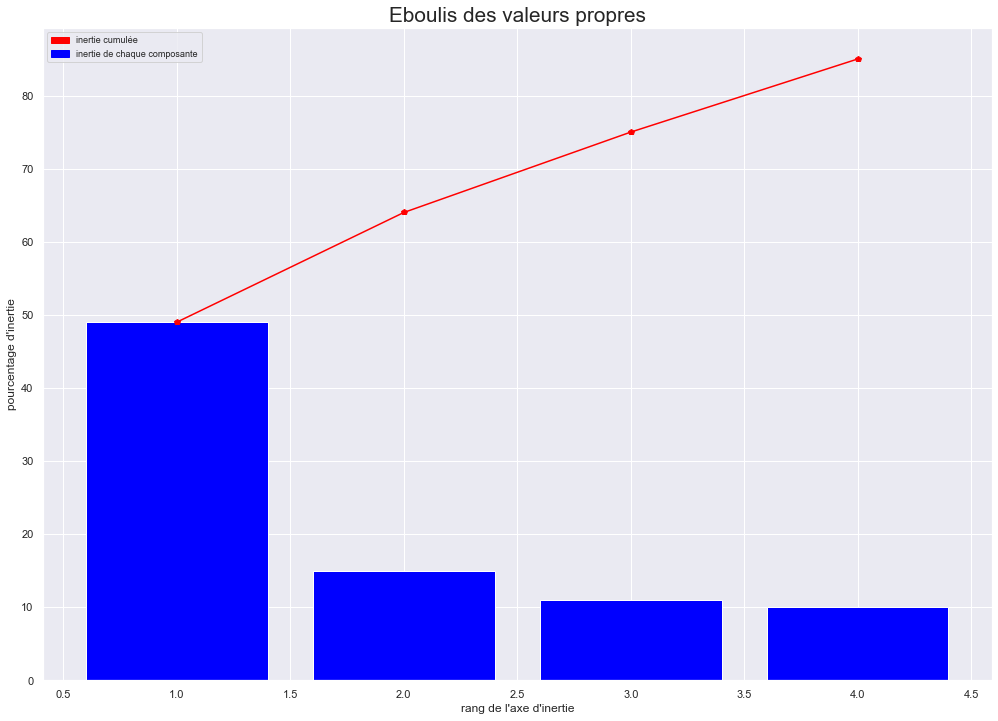

In [34]:
# Affichage graphique.
plt.bar(x_list, scree, color='blue')
plt.plot(x_list, scree_cum,c="red", marker='p')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")

red_patch = mpatches.Patch(color='red', label='inertie cumulée')
blue_patch = mpatches.Patch(color='blue', label='inertie de chaque composante')
plt.legend(loc='upper left', fontsize=9, handles=[red_patch, blue_patch])

plt.show()

<AxesSubplot:>

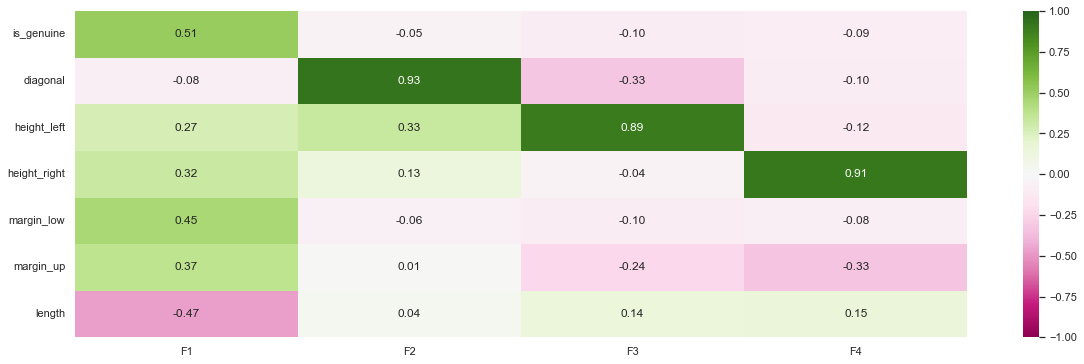

In [35]:
pcs = pca.components_
pcs
features = df_final.columns
pcs = pd.DataFrame(pcs, columns = features)
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="PiYG", fmt="0.2f")

In [36]:
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2", "PC3", "PC4"])
X_proj[:10]

,PC1,PC2,PC3,PC4
0,0.960720,0.920086,2.847204,3.057132
1,-2.053923,-2.269012,-1.018557,0.141855
2,-1.216235,2.605583,0.989721,-1.142449
3,-1.556951,-1.811609,0.758836,0.801213
4,-0.232895,-0.520956,0.829912,-1.691964
5,-0.949825,0.418143,-0.806482,0.870549
6,-0.221284,1.335662,0.013338,-0.462131
7,-1.351126,-0.393426,-0.296614,1.096592
8,-1.094010,1.420217,-0.775107,-0.816894
9,-0.908653,1.753186,-0.284265,0.202430


In [37]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    
    # mutation de X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # paramétrage des labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # initialisation       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # paramétrage des points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # calcul du % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # noms axes avec % inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}', fontsize=15)
    ax.set_ylabel(f'F{y+1} {v2}', fontsize=15)

    # valeurs x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # Bornes x et y 
    ax.set_xlim(left=-3, right=4)
    ax.set_ylim(bottom=-2, top=3)

    # display quadrillage
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.2)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.2)

    # display labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='20', ha='center', va='center') 

    # Paramétrage titre et affichage 
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})", fontsize=15)
    #plt.xlabel('', fontsize=20)
    #plt.ylabel("",fontsize=20)
    #plt.yticks(fontsize=15)
    #plt.xticks(fontsize=15)
    plt.show()

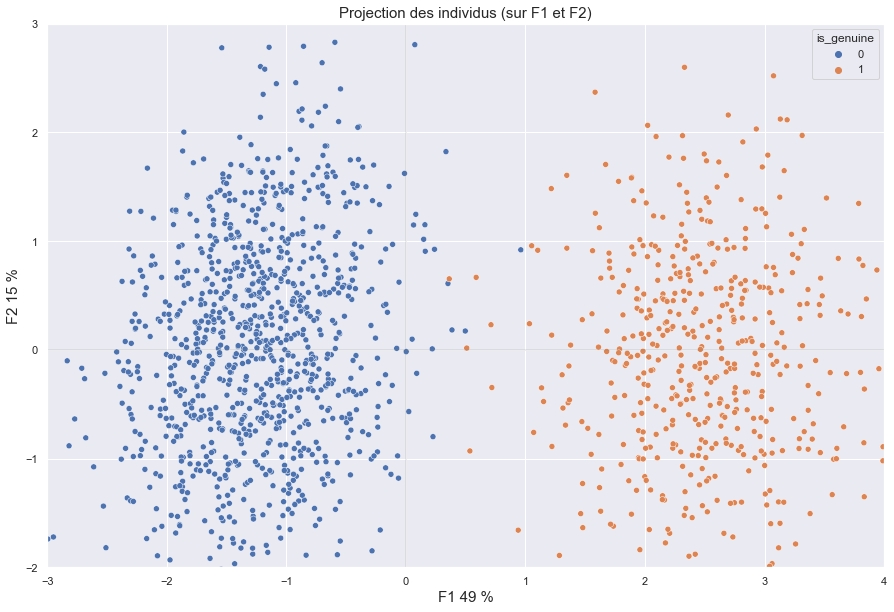

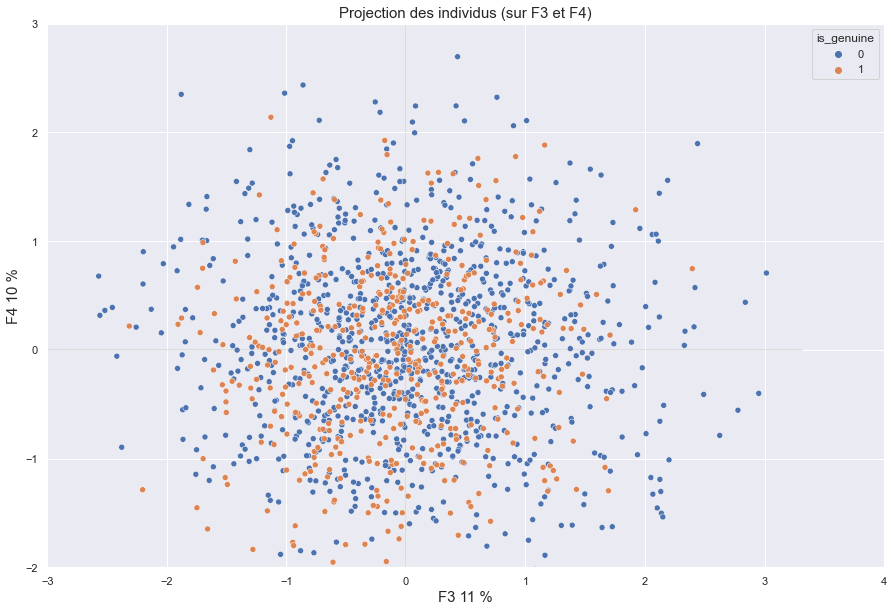

In [38]:
display_factorial_planes(X_proj,  
                         x_y=(0,1), 
                         clusters=df_final['is_genuine'], 
                         pca=pca,
                         figsize=(15,10),                           
                         alpha=1,
                         marker ="s")        

display_factorial_planes(X_proj,  
                         x_y=(2,3), 
                         clusters=df_final['is_genuine'], 
                         pca=pca, 
                         figsize=(15,10),                          
                         alpha=1, 
                         marker ="s")  

#### III/- Prédictions

In [39]:
# Définition de X et y 
y =  df_final["is_genuine"]
X =  df_final.drop(["is_genuine"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

##### III/-A/- K-Means

In [40]:
# Objectif : déterminer le nombre optimal de clusters par la méthode du coude
# cluster_max : nombre maximal de clusters à tester
def my_kmeans_coude(X, cluster_max=10, graphique=True):  
    inertia = []
    k_list = range(1, cluster_max)
    for k in k_list :
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
    # "optimal_index" = indice du nombre de clusters optimal
    optimal_index = np.argmin(np.diff(inertia)) + 1

    # Récupérer le nombre de clusters optimal
    n_clusters = optimal_index + 1
    print("Le nombre de cluster optimal est",n_clusters)
    return n_clusters

c:\Users\Matthieu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


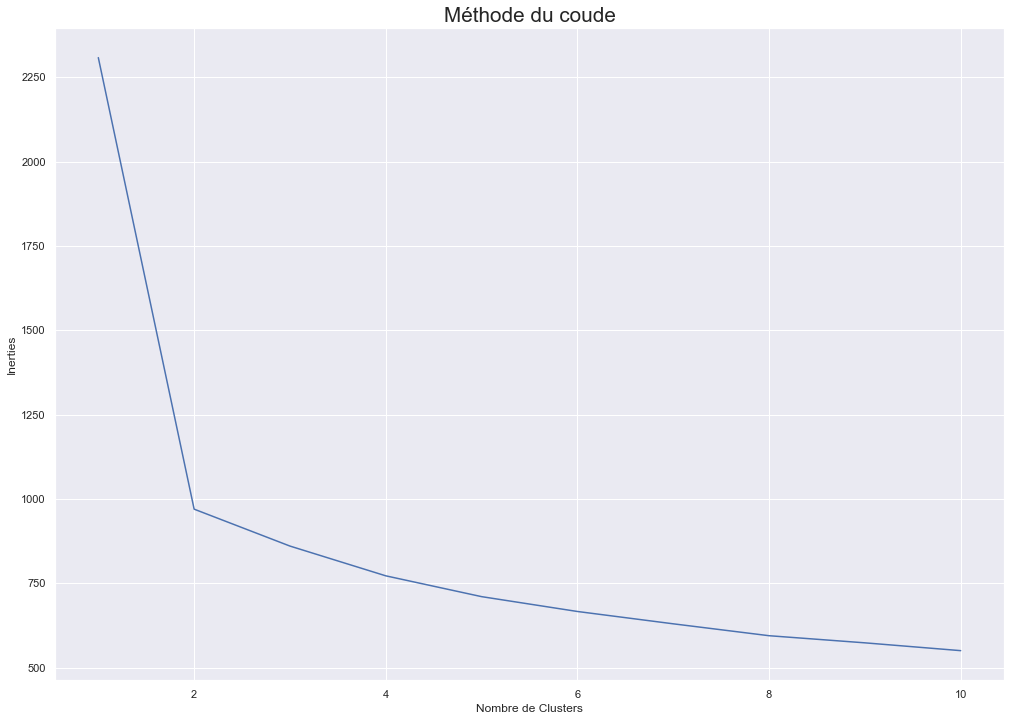

In [41]:
# Graph du coude pour trouver le nombre optimal de clusters
graph = []
inertie = {}
for i in range(1,11):
    km=KMeans(n_clusters=i)
    km.fit(X)
    graph.append(km.inertia_)
    inertie[i] = km.inertia_
plt.plot(range(1,11), graph)
plt.title('Méthode du coude')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inerties')
plt.show()

In [42]:
# nombre optimal de clusters récupéré par la fonction my_kmeans_coude()
n_clusters = my_kmeans_coude(X_train, graphique=False)

c:\Users\Matthieu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Le nombre de cluster optimal est 2


In [43]:
# "model_km" = variable avec la fonction KMeans et le nb de clusters
model_km = KMeans(n_clusters, random_state=0)
# on ajuste 'model_km' au jeu de données 'train'
model_km.fit(X_train,y_train)

KMeans(n_clusters=2, random_state=0)

In [44]:
# array 'predictionKM' = prédiction sur les données 'test' à partir de notre modèle
predictionKM = model_km.predict(X_test)
# On vérifie le score de notre model sur les données Test (F1 score)
score_f1 = f1_score(y_test, predictionKM)
score_f1 = round(score_f1*100,4)
print("Le score du modèle de K-Means sur les données de test est de :", score_f1,"%")

Le score du modèle de K-Means sur les données de test est de : 97.2152 %


In [45]:
cfk = confusion_matrix(y_test, predictionKM)

<AxesSubplot:title={'center':'Matrice de confusion K-Means'}>

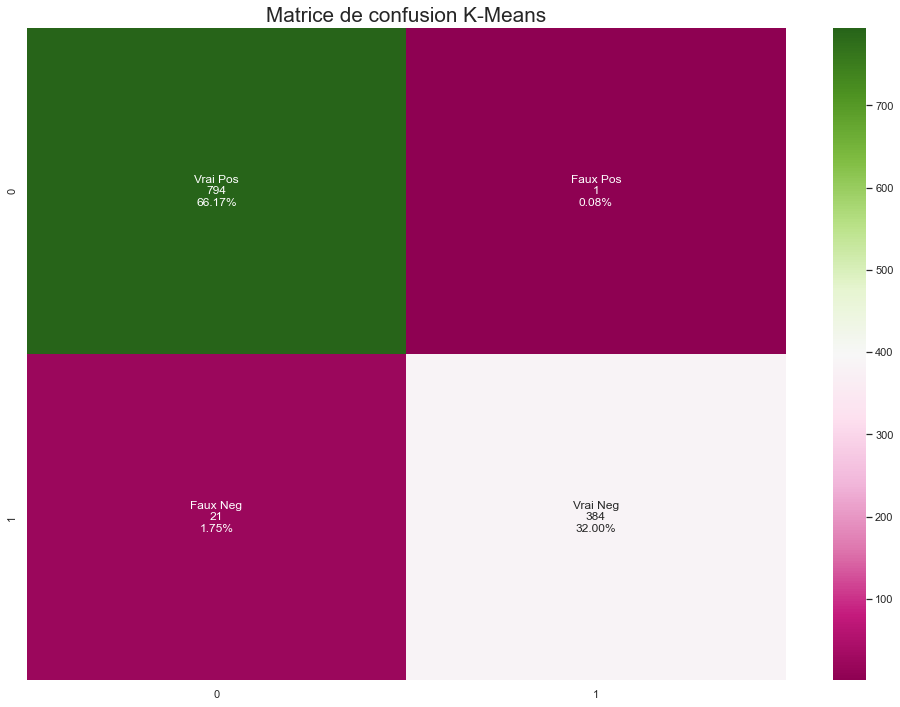

In [46]:
import seaborn as sns
group_names = ["Vrai Pos","Faux Pos","Faux Neg","Vrai Neg"]
group_counts = ["{0:0.0f}".format(value) for value in
                cfk.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cfk.flatten()/np.sum(cfk)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title("Matrice de confusion K-Means")
sns.heatmap(cfk, annot=labels, fmt="", cmap='PiYG')
# source : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

##### III/-B/- Régression logistique

In [47]:
# définition du modele
modele_rl =  LogisticRegression()

# entrainement du modele
modele_rl = modele_rl.fit(X_train,y_train)

# prédictions dans une variable y_predict_rl
y_predict_rl = modele_rl.predict(X_test)

In [48]:
# On vérifie le score de notre model sur les données Test (F1 score)
score_f1 = f1_score(y_test, y_predict_rl)
score_f1 = round(score_f1*100,4)
print("Le score du modèle de RL sur les données de test est de :", score_f1,"%")

Le score du modèle de RL sur les données de test est de : 97.4811 %


In [49]:
## faire aussi train

In [50]:
Cfrl = confusion_matrix(y_test, y_predict_rl)

<AxesSubplot:title={'center':'Matrice de confusion régression logistique'}>

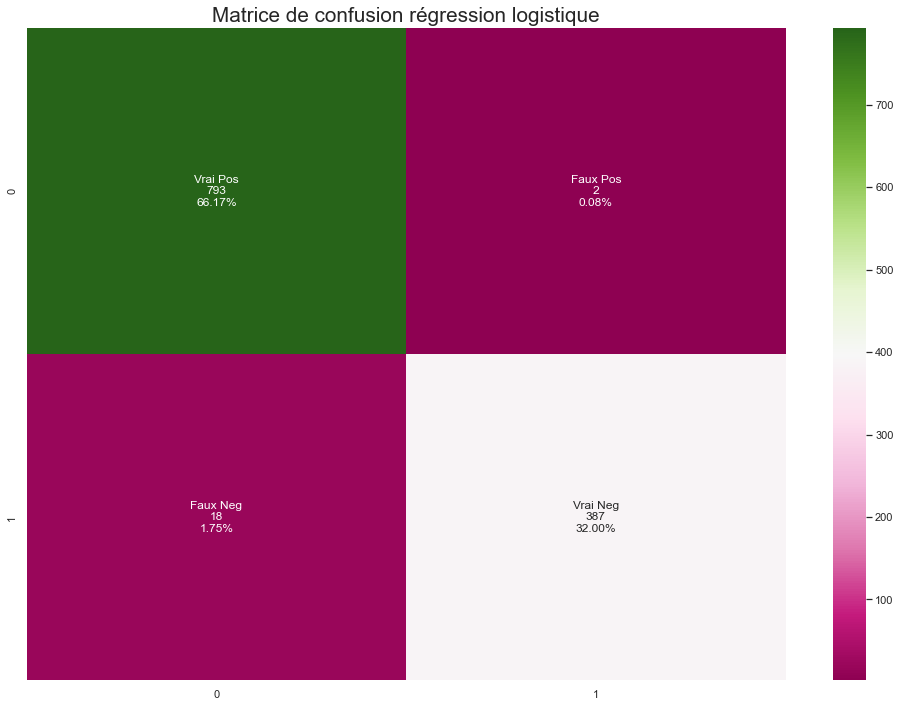

In [51]:
import seaborn as sns
group_names = ["Vrai Pos","Faux Pos","Faux Neg","Vrai Neg"]
group_counts = ["{0:0.0f}".format(value) for value in
                Cfrl.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cfk.flatten()/np.sum(cfk)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title("Matrice de confusion régression logistique")
sns.heatmap(Cfrl, annot=labels, fmt="", cmap='PiYG')

##### III/-C/- Analyse

In [52]:
# probabilités de prédictions exactes
probDf = modele_rl.predict_proba(X)
probDf

array([[0.59836097, 0.40163903],
       [0.99826133, 0.00173867],
       [0.95788538, 0.04211462],
       ...,
       [0.02402901, 0.97597099],
       [0.08177074, 0.91822926],
       [0.32574402, 0.67425598]])

In [53]:
# création de colonne dans le df "X_test" avec les labels de "prediction de KM"
X_test["predictionKM"] = predictionKM
# création de colonne dans le df "X_test" avec les labels de "prediction de RL"
X_test["predictionRL"] = y_predict_rl

In [54]:
# df_pred_check = df de test (merger on index)
df_pred_check = X_test.join(y_test)
# source : https://www.statology.org/pandas-merge-on-index/ 

###### III/-C/-1/- "erreurs" RL et KM, "décalages" entre ces "erreurs"   

In [55]:
# df avec les index des erreurs RL
erreursRL = df_pred_check[df_pred_check['is_genuine'] != df_pred_check['predictionRL']]

In [56]:
# df avec les index des errreurs
erreursKM = df_pred_check[df_pred_check['is_genuine'] != df_pred_check['predictionKM']]

In [57]:
# df "decalage" : dans le df "erreursKM", les index qui sont dans ['predictionKM'] mais qui ne sont pas dans ['predictionRL']  
decalage = erreursKM[erreursKM['predictionKM'] != erreursKM['predictionRL']]

In [58]:
# df "decalage1" : dans le df "erreursRL", les index qui sont dans ['predictionKM'] mais qui ne sont pas dans ['predictionRL']  
decalage1 = erreursRL[erreursRL['predictionKM'] != erreursRL['predictionRL']]

In [59]:
erreursCommunes = erreursKM[erreursKM['predictionKM'] == erreursKM['predictionRL']]

###### III/-C/-2/- Synthèse des "erreurs" et "décalages"

In [60]:
# Index des deux datasets d'erreurs ("faux positifs" ou "faux négatifs")
def analysis_df_start(df_input):
    display(df_input.index)
analysis_df_start(erreursRL)
analysis_df_start(erreursKM)
analysis_df_start(decalage)
analysis_df_start(decalage1) 
analysis_df_start(erreursCommunes)

Int64Index([1083, 1087, 1362, 1073, 1024, 1388,  728, 1190, 1103, 1081,  669,
            1062, 1025, 1407, 1122, 1270, 1325, 1281, 1452, 1160],
           dtype='int64')

Int64Index([1083, 1223, 1087, 1073, 1024,  728, 1150, 1190, 1103, 1078, 1081,
            1062, 1025, 1407, 1122, 1270, 1325, 1281, 1452, 1130, 1341, 1160],
           dtype='int64')

Int64Index([1223, 1150, 1078, 1130, 1341], dtype='int64')

Int64Index([1362, 1388, 669], dtype='int64')

Int64Index([1083, 1087, 1073, 1024,  728, 1190, 1103, 1081, 1062, 1025, 1407,
            1122, 1270, 1325, 1281, 1452, 1160],
           dtype='int64')

Erreurs de la méthode Reg log :   
    - index des 2 "faux négatifs" : 728 et 669   
    - index des 18 "faux positifs" : 1083, 1087, 1362, 1073, 1024, 1388, 1190, 1103, 1081, 1062, 1025, 1407, 1122, 1270, 1325, 1281, 1452, 1160

Erreurs de la méthode K-MEANS :   
    - index du "faux négatif" : 728   
    - index des 21 "faux positifs" : 1083, 1223, 1087, 1073, 1024, 1150, 1190, 1103, 1078, 1081, 1062, 1025, 1407, 1122, 1270, 1325, 1281, 1452, 1130, 1341, 1160
df "erreursCommunes" entre les prédiction RL et KM. Il y a 17 index : 1083, 1087, 1073, 1024,  728, 1190, 1103, 1081, 1062, 1025, 1407, 1122, 1270, 1325, 1281, 1452, 1160

df "decalage" : dans le df "erreursKM", les index qui sont dans ['predictionKM'] mais qui ne sont pas dans ['predictionRL']. Il y a 5 index : 1223, 1150, 1078, 1130, 1341

df "decalage1" : dans le df "erreursRL", les index qui sont dans ['predictionKM'] mais qui ne sont pas dans ['predictionRL']. Il y a 3 index : 1362, 1388, 669

###### III/-C/-3/- Synthèse des médianes des "erreurs" et "décalages"

In [61]:
# Calculs des médianes de df_final et des df "faux positifs"   
def analysis_df_start(df_input):
    display(df_input.median())    
analysis_df_start(df_true)
analysis_df_start(df_faux)
analysis_df_start(df_final)
analysis_df_start(erreursRL)
analysis_df_start(erreursKM)
analysis_df_start(decalage)
analysis_df_start(decalage1) 
analysis_df_start(erreursCommunes)

is_genuine        0.000
diagonal        171.990
height_left     103.950
height_right    103.810
margin_low        4.110
margin_up         3.050
length          113.205
dtype: float64

is_genuine        1.00
diagonal        171.91
height_left     104.18
height_right    104.16
margin_low        5.19
margin_up         3.35
length          111.63
dtype: float64

is_genuine        0.00
diagonal        171.96
height_left     104.04
height_right    103.92
margin_low        4.31
margin_up         3.14
length          112.96
dtype: float64

diagonal        171.865
height_left     104.130
height_right    104.100
margin_low        4.585
margin_up         3.340
length          112.570
predictionKM      0.000
predictionRL      0.000
is_genuine        1.000
dtype: float64

diagonal        171.895
height_left     104.195
height_right    104.145
margin_low        4.560
margin_up         3.375
length          112.630
predictionKM      0.000
predictionRL      0.000
is_genuine        1.000
dtype: float64

diagonal        171.94
height_left     104.31
height_right    104.28
margin_low        5.23
margin_up         3.47
length          112.94
predictionKM      0.00
predictionRL      1.00
is_genuine        1.00
dtype: float64

diagonal        171.56
height_left     104.09
height_right    104.20
margin_low        4.72
margin_up         3.02
length          112.47
predictionKM      1.00
predictionRL      0.00
is_genuine        1.00
dtype: float64

diagonal        171.88
height_left     104.15
height_right    104.07
margin_low        4.55
margin_up         3.36
length          112.60
predictionKM      0.00
predictionRL      0.00
is_genuine        1.00
dtype: float64

- Dans les 2 méthodes, il y a des "faux positifs" et des "faux négatifs".  
    - "Faux positifs" : billets classés comme vrais (valeur 1) alors qu'ils sont faux (valeur 0).  
    - "Faux négatifs" : billets classés comme faux (valeur 0) alors qu'ils sont vrais (valeur 1).  
<br/>
- La régression logistique est la plus performante avec uniquement 20 erreurs contre 22 avec le K-Means. Elle compte 18 "faux positifs" et 2 "faux négatifs".  
- Il y a 17 billets qui se retrouvent dans les deux datasets d'erreurs. Ces sont majoritairement des "faux positifs".   
<br/>
- [Calculs de départ] Caractéristiques des "faux billets" :   
    - une diagonale et une longueur plus petites ;   
    - une hauteur et des marges plus grandes.  
<br/>
- La médiane des "faux positifs" et des "faux négatifs" suit les caractéristiques (ci-dessus) des "faux billets" par rapport à la médiane des "vrais billets". 

#### IV/- Test

In [62]:
# df_test = pd.read_csv("../Documents/DAN-P10-data/billets_production.csv", sep=",")
df_test1 = pd.read_csv("C:/Users/Matthieu/Documents/DAN-P10-data/billets_production.csv", sep=",")
df_test = df_test1.set_index(df_test1["id"])
df_test = df_test.drop(["id"], axis=1)

In [63]:
ff = modele_rl.predict_proba(df_test)
# créer array avec les marges d'erreurs
marge_er1 = ff[0:3,0]
marge_er2 = ff[3:5,1]
marge_erreur = np.concatenate((marge_er1, marge_er2))

In [64]:
# standardisation des données
std_scale = preprocessing.StandardScaler().fit(df_test)
X_scaled = std_scale.transform(df_test)
# prédiction des billets
df_test.loc[df_test.index,"prediction"] = modele_rl.predict(X_scaled)

c:\Users\Matthieu\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [65]:
df_test['marge_erreur'] = marge_erreur
# Renvoie la probabilité de l'échantillon pour chaque classe du modèle, où les classes sont classées comme elles le sont dans self.classes_.

In [66]:
# Affichage
res= []
for i in df_test['prediction'] :
    if i == 1 :
        res.append('faux billet')
    else :
        res.append('vrai billet')
df_test['prediction'] = res

print(df_test['prediction'].value_counts())

df_test.head()

faux billet    3
vrai billet    2
Name: prediction, dtype: int64


,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,marge_erreur
id,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,faux billet,0.018046
A_2,171.87,104.17,104.13,6.00,3.31,112.09,faux billet,0.009908
A_3,172.00,104.58,104.29,4.99,3.39,111.57,faux billet,0.008774
A_4,172.49,104.55,104.34,4.44,3.03,113.20,vrai billet,0.102195
A_5,171.65,103.63,103.56,3.77,3.16,113.33,vrai billet,0.001337


#### V/- Projection des deux prédictions

In [67]:
# col name 'id' -> 'is_genuine'
df_test1.rename(columns = {'id':'is_genuine'}, inplace = True)
# valeur 3 pour les "faux billets" et valeur 2 pour les "vrais billets" de la 'prédiction test'
df_test1 = df_test1.replace({'is_genuine': {'A_1':3, 'A_2':3, 'A_3':3, 'A_4':2, 'A_5':2}})
# df_testFinal = données de df_final et df_test1  
df_testFinal = df_final.append(df_test1, ignore_index = True)

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_7520\3953326269.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_testFinal = df_final.append(df_test1, ignore_index = True)


In [68]:
# Centrage et réduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_testFinal)
pca = PCA(n_components=4)
pca.fit(X_scaled)
scree = (pca.explained_variance_ratio_*100).round()
scree_cum = scree.cumsum().round()
# Travail sur les 4 premières composantes.
n_components = 4
# Définition de la variable 'x_list' avec la liste de nos composantes.
x_list = range(1, n_components+1)
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2", "PC3", "PC4"])
X_proj[:10]

,PC1,PC2,PC3,PC4
0,0.972500,0.975575,2.911992,2.976183
1,-2.056990,-2.274124,-0.988331,0.190389
2,-1.208657,2.602973,0.935026,-1.200239
3,-1.556004,-1.794941,0.797448,0.801067
4,-0.223837,-0.533096,0.784368,-1.694265
5,-0.947211,0.421207,-0.784838,0.885391
6,-0.212633,1.330213,-0.014376,-0.469306
7,-1.350041,-0.383039,-0.261415,1.105884
8,-1.088571,1.404940,-0.810326,-0.806996
9,-0.902026,1.753132,-0.297489,0.197181


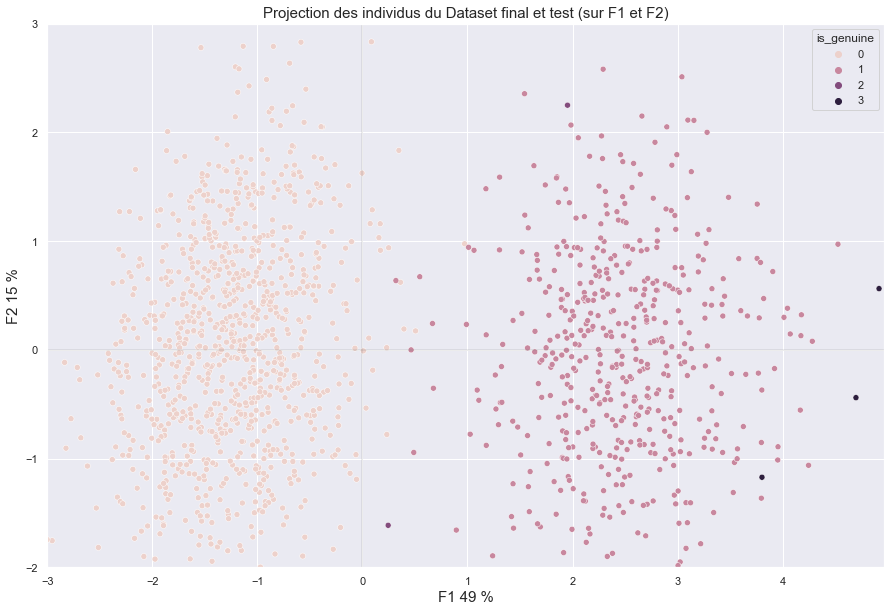

In [69]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="x"):
    
    # mutation de X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)
        

    # paramétrage des labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # initialisation       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # paramétrage des points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # calcul du % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # noms axes avec % inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}', fontsize=15)
    ax.set_ylabel(f'F{y+1} {v2}', fontsize=15)

    # valeurs x max et y max
    x_max = np.abs(X_[:, x]).max() *1.01
    y_max = np.abs(X_[:, y]).max() *1.01

    # Bornes x et y 
    ax.set_xlim(left=-3, right=x_max)
    ax.set_ylim(bottom=-2, top=3)

    # display quadrillage
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.2)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.2)

    # display labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x+1000, _y+1000, labels[i], fontsize='170000', ha='center', va='center') 

    # Paramétrage titre et affichage 
    plt.title(f"Projection des individus du Dataset final et test (sur F{x+1} et F{y+1})", fontsize=15)
    #plt.xlabel('', fontsize=20)
    #plt.ylabel("",fontsize=20)
    #plt.yticks(fontsize=15)
    #plt.xticks(fontsize=15)
    plt.show()

display_factorial_planes(X_proj,  
                         x_y=(0,1), 
                         clusters=df_testFinal['is_genuine'],
                         figsize=(15,10),   
                         pca=pca,                        
                         alpha=1,
                         marker ="x") 
#source : https://stackoverflow.com/questions/46492964/array-length-does-not-match-index-length-by-mixing-list-and-dataframe-columns

In [ ]:
# model = LogisticRegression(C=1)

In [ ]:
# model.fit(X, y)

In [ ]:
# model.predict_proba(X).round(4)[:5]

In [ ]:
# pred = model.predict(X)

In [ ]:
# accuracy_score(y, pred)

In [ ]:
# Xc = X[y == pred]
# Xf = X[y != pred]

In [ ]:
"""
plt.figure(figsize=(10, 6))
plt.scatter(x=Xc[:, 0], y=Xc[:, 1], c=y[y == pred],
            marker='o', cmap='coolwarm')
plt.scatter(x=Xf[:, 0], y=Xf[:, 1], c=y[y != pred],
            marker='x', cmap='coolwarm');
            """

#### VI/- Test Soutenance

In [70]:
# df_test = pd.read_csv("../Documents/DAN-P10-data/billets_production.csv", sep=",")
df_soutenance = pd.read_csv("C:/Users/Matthieu/Documents/DAN-P10-data/billets_soutenance.csv", sep=",")
df_soutenance = df_soutenance.set_index(df_soutenance["id"])
df_soutenance = df_soutenance.drop(["id"], axis=1)

In [71]:
ff = modele_rl.predict_proba(df_soutenance)
# créer array avec les marges d'erreurs
marge_er1 = ff[0:3,0]
marge_er2 = ff[3:5,1]
marge_erreur = np.concatenate((marge_er1, marge_er2))

In [72]:
# standardisation des données
std_scale = preprocessing.StandardScaler().fit(df_soutenance)
X_scaled = std_scale.transform(df_soutenance)
# prédiction des billets
df_soutenance.loc[df_soutenance.index,"prediction"] = modele_rl.predict(X_scaled)

c:\Users\Matthieu\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [73]:
df_soutenance['marge_erreur'] = marge_erreur
# Renvoie la probabilité de l'échantillon pour chaque classe du modèle, où les classes sont classées comme elles le sont dans self.classes_.

In [74]:
# Affichage
res= []
for i in df_soutenance['prediction'] :
    if i == 1 :
        res.append('faux billet')
    else :
        res.append('vrai billet')
df_soutenance['prediction'] = res

print(df_soutenance['prediction'].value_counts())

df_soutenance.head()

faux billet    3
vrai billet    2
Name: prediction, dtype: int64


,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,marge_erreur
id,,,,,,,,
A_3,172.00,104.58,104.29,4.99,3.39,111.57,faux billet,0.008774
A_4,172.49,104.55,104.34,4.44,3.03,113.20,vrai billet,0.897805
A_5,171.65,103.63,103.56,3.77,3.16,113.33,vrai billet,0.998663
A_1,171.76,104.01,103.54,5.21,3.30,111.42,faux billet,0.981954
A_2,171.87,104.17,104.13,6.00,3.31,112.09,faux billet,0.990092
